# A class for Gaussian distributed random vectors
A vector with a covariance matrix (error bars along the diagonal).

In [1]:
from numpy        import array, mean, cov, isscalar, asarray
from numpy.linalg import cholesky, inv
from numpy.random import randn

Some relevant infos about how to implement it correctly:

* why to subclass `ndarray`: 
  https://stackoverflow.com/questions/38229953/array-and-rmul-operator-in-python-numpy
* why to implement `__new__`:
  https://numpy.org/doc/stable/user/basics.subclassing.html

Here we keep it a bit hacky...

In [2]:
# helper functions for slicing of two-D arrays
def pick2(A, idx0, idx1=None):
    if idx1 is None:
        idx1 = idx0
    idx0 = [[i] for i in idx0]   # weird numpy slicing
    # https://stackoverflow.com/questions/4257394/slicing-of-a-numpy-2d-array-or-how-do-i-extract-an-mxm-submatrix-from-an-nxn-ar
    return A[idx0, idx1]

def inverse_range(l, idx):
    return [i for i in range(l) if i not in idx]

In [3]:
class GaussianRV():
    
    def __init__(self, mu, Sigma):
        if isscalar(mu):
            mu = asarray([[mu]])
        if isscalar(Sigma):
            Sigma = asarray([[Sigma]])
        self.mu    = mu         # a vector
        self.Sigma = Sigma      # must be a matrix
        self.L     = cholesky(Sigma)   # L == sqrt(Sigma)
        
    def __repr__(self):
        s = f"GaussianRV of shape {self.mu.shape}"
        if self.mu.shape[0] < 7:
            s += f"\nparameter mu    = \n{self.mu}"
            s += f"\nparameter Sigma = \n{self.Sigma}"
        return s
    
    def __add__(self, other):
        # overload self + other
        if isinstance(other, GaussianRV):
            # adding another GaussianRV
            return GaussianRV(self.mu    + other.mu, 
                              self.Sigma + other.Sigma)
        else:
            # adding a constant
            return GaussianRV(self.mu + other, self.Sigma)
    
    def __minus__(self, other):
        # overload self - other
        # note that the variances are added
        return GaussianRV(self.mu    - other.mu,
                          self.Sigma + other.Sigma)
    
    def __mul__(self, other):
        # for scalar multiplication
        # overload self * other
        return GaussianRV(other*self.mu,
                          other*other*self.Sigma)
        
    def __rmul__(self, other):
        # overload other * self
        return self * other
    
    def sample(self, n=1):
        return self.L @ randn(self.mu.shape[0], n) + self.mu

    def lin_trafo(self, A, b=None):
        # linear transformation of a Gaussian
        Y = GaussianRV(A @ self.mu, 
                       A @ self.Sigma @ A.T)
        if b is not None:
            Y = Y + b
        return Y
        
    def sum(self, keep_idx):
        # 'keep_idx' contains the indices to keep,
        # i.e. all others are summed out
                return GaussianRV(mu[keep_idx], pick2(Sigma, keep_idx))
        
    def cond(self, cond_idx, cond_values):
        # let's use the notation of section06/slide21
        assert (cond_values.shape == self.mu[cond_idx].shape), "shape of conditional does not match"
        keep_idx = inverse_range(self.mu.shape[0], cond_idx)
        mu, nu   = self.mu[keep_idx], self.mu[cond_idx]
        print(mu)
        print(nu)
        A, C     = pick2(Sigma, keep_idx), pick2(Sigma, cond_idx)
        B        = pick2(Sigma, keep_idx, cond_idx)
        return GaussianRV(mu + B @ inv(C) @ (cond_value - nu),  # cond mean
                          A  - B @ inv(C) @ B.T)                # cond var


In [4]:
# test
mu    = randn(5,1)
A     = randn(5,5)
Sigma = A@A.T   # symmetrize A
X     = GaussianRV(mu, Sigma)
print(X)

GaussianRV of shape (5, 1)
parameter mu    = 
[[ 0.86944036]
 [ 0.2177893 ]
 [ 0.5072294 ]
 [-0.79800416]
 [-0.46285696]]
parameter Sigma = 
[[ 3.86059716 -1.10083396 -0.44180812  1.47934822 -1.52275099]
 [-1.10083396  4.30330503  1.3948638  -1.22710971  0.06028574]
 [-0.44180812  1.3948638   2.81169142 -0.29177485  0.66375475]
 [ 1.47934822 -1.22710971 -0.29177485  1.81517099 -1.05751388]
 [-1.52275099  0.06028574  0.66375475 -1.05751388  2.09586009]]


In [5]:
# sum out some of the coordinates
keep_idx = [0, 2]
Y = X.sum(keep_idx)
Y

GaussianRV of shape (2, 1)
parameter mu    = 
[[0.86944036]
 [0.5072294 ]]
parameter Sigma = 
[[ 3.86059716 -0.44180812]
 [-0.44180812  2.81169142]]

In [6]:
# condition on a value
cond_idx = [1,3,4]
cond_value = array([[0.0], [0.0], [0.0]])
Z = X.cond(cond_idx, cond_value)
print(Z)                   

[[0.86944036]
 [0.5072294 ]]
[[ 0.2177893 ]
 [-0.79800416]
 [-0.46285696]]
GaussianRV of shape (2, 1)
parameter mu    = 
[[1.01505772]
 [1.01412529]]
parameter Sigma = 
[[2.31124223 0.19133916]
 [0.19133916 1.97028339]]


In [7]:
# sample from the conditional distribution
print(Z)
z = Z.sample(10000)
print('empirical parameters')
print(mean(z, axis=1))   # calling `mean` from numpy
print(cov(z))            # calling `cov` from numpy

GaussianRV of shape (2, 1)
parameter mu    = 
[[1.01505772]
 [1.01412529]]
parameter Sigma = 
[[2.31124223 0.19133916]
 [0.19133916 1.97028339]]
empirical parameters
[1.00295906 1.00306993]
[[2.2877466  0.18241463]
 [0.18241463 1.96336015]]


In [8]:
# linear transformation
A = randn(3, 5)
b = randn(3, 1)
Z = X.lin_trafo(A, b)
print(Z)

GaussianRV of shape (3, 1)
parameter mu    = 
[[-1.26736696]
 [-1.6307806 ]
 [-3.88595572]]
parameter Sigma = 
[[ 7.96982777  1.96640535 -1.21319612]
 [ 1.96640535 11.49028547  6.03240573]
 [-1.21319612  6.03240573  7.14788018]]


### Playing around with Gaussian prior, likelihood and posterior
Let's assume a Gaussian prior and likelihood, 
$$ p(x) = \mathcal{N}(x, \mu_0, \sigma_0^2)$$
$$ p(y|x) = \mathcal{N}(y|x, \tau^2)$$
which imply a Gaussian posterior,
$$ p(x|y) = \mathcal{N}(x|\mu_1(y),\sigma_1^2)$$
with posterior mean $\mu_1$ and posterior variance $\sigma_1^2$:
$$ \mu_1 = \frac{\sigma_0^{-2}\mu+\tau^{-2}y}{\sigma_0^{-2}+\tau^{-2}}=
\frac{\sigma_1^2}{\sigma_0^2}\mu + \frac{\sigma_1^2}{\tau^2}y$$
$$ \sigma_1^2 = \frac{1}{\sigma_0^{-2}+\tau^{-2}}
= \frac{1}{1/\sigma_0^2 + 1/\tau^2}$$
where we just rewrote the formulas a bit.

In [9]:
from ipywidgets        import interact
import matplotlib.pyplot as plt
from numpy             import linspace
from numpy.random      import randn
from scipy.stats       import norm
from math              import sqrt
plt.rcParams['figure.figsize'] = (10, 6)

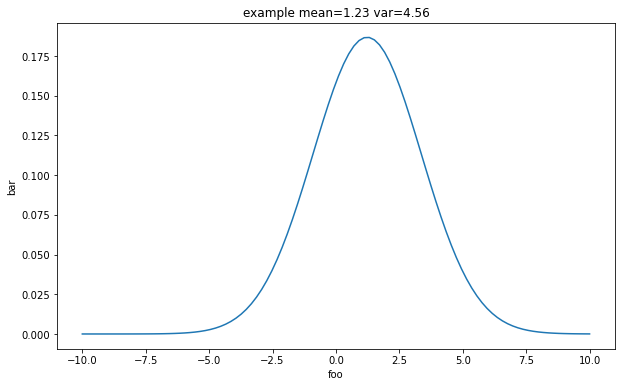

In [10]:
def plot_gaussian(mu, sigma_squared, name='', xlabel='', ylabel=''):
    n = 100
    x = linspace(-10, 10, n)
    plt.plot(x, norm.pdf(x, loc=mu, scale=sqrt(sigma_squared)))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{name} mean={round(mu,2)} var={round(sigma_squared,2)}")
plot_gaussian(1.23, 4.56, 'example', 'foo', 'bar')

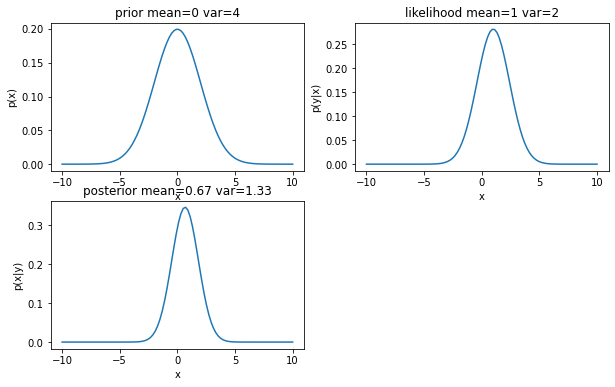

In [11]:
def plot_pdfs(y, mu0, sigma0_sq, tau_sq): 
    sigma1_sq = 1/(1/sigma0_sq + 1/tau_sq)
    mu1       = sigma1_sq*(mu0/sigma0_sq + y/tau_sq)
    plt.subplot(221)
    plot_gaussian(mu0, sigma0_sq, 'prior',      'x', 'p(x)')
    plt.subplot(222)
    plot_gaussian(y,   tau_sq,    'likelihood', 'x', 'p(y|x)')
    plt.subplot(223)
    plot_gaussian(mu1, sigma1_sq, 'posterior',  'x', 'p(x|y)')
plot_pdfs(1, 0, 4, 2)

In [12]:
interact(plot_pdfs, 
         y=(-10,10,1), mu0=(-10,10,1), 
         sigma0_sq=(1,10,1), tau_sq=(1,10,1))

interactive(children=(IntSlider(value=0, description='y', max=10, min=-10), IntSlider(value=0, description='mu…

<function __main__.plot_pdfs(y, mu0, sigma0_sq, tau_sq)>